In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from PIL import Image

In [2]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [268]:
def draw_labels(image, labels_df, thickness, color, fill_poly):
    for row in range(labels_df.shape[0]):
        pts = np.array(labels_df.loc[row]).reshape((-1,1,2))
        if fill_poly:
            image = cv.fillPoly(image, np.int32([pts]), color=rgb(color))
        else:
            image = cv.polylines(image, np.int32([pts]), True, color=compute_rgb(color), thickness=thickness)
    
    return image

In [269]:
def compute_rgb(hex_color):
    return tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))

In [48]:
thickness = 5
magnet_color = "#00cccc"
tissue_color = "#ff6666"

fill_poly = False

In [372]:
rgb = True

if(rgb==True):
    path_rgb = "rgb"
else:
    path_rgb="intensity"

In [373]:
DATASET_NUMBER = 3

AUGMENTED_DATASET_PATH = "../augmented_dataset"
WAFER_CROPPED_PATH = f"{AUGMENTED_DATASET_PATH}/wafer_{path_rgb}_cropped_{str(DATASET_NUMBER)}"
TEST_IMAGES_PATH = "test_images"

### Cropped Section Example

In [374]:
path_img= f"{WAFER_CROPPED_PATH}/extract/0.tif"
if os.path.isfile(path_img):
    if(rgb==True):
        section = cv.imread(path_img)
    else:
        section = cv.imread(path_img,0)
else:
    print ("The file " + path_img + " does not exist.")

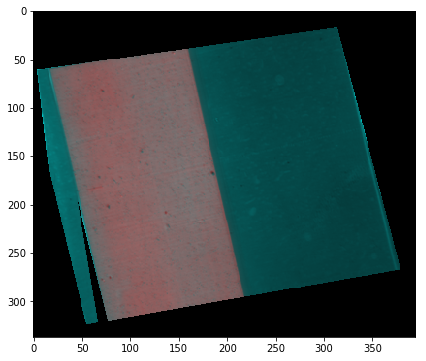

In [375]:
plt.figure(figsize=(8, 6))
plt.imshow(section)

In [376]:
section.shape

(337, 395, 3)

In [377]:
height_section = section.shape[0]
width_section = section.shape[1]

In [378]:
if(rgb==True):
    init_img = np.zeros([height_section,width_section,3],dtype=np.uint8)
else:
    init_img = np.zeros([height_section,width_section],dtype=np.uint8)
sub = init_img

In [379]:
if(rgb==True):
    test_section = np.mean(section,axis=2)
else:
    test_section = section

In [380]:
# Boolean matrix which is true is not 0 (the pixel has a value, and is the potentially the object)
ind_true = test_section > 0

In [381]:
for i in range(height_section):
    for j in range(width_section):
        if(ind_true[i,j] == True):
            sub[i,j] = section[i,j]
        else:
            if(rgb==True):
                sub[i,j] = [0,0,0]
            else:
                sub[i,j] = 0

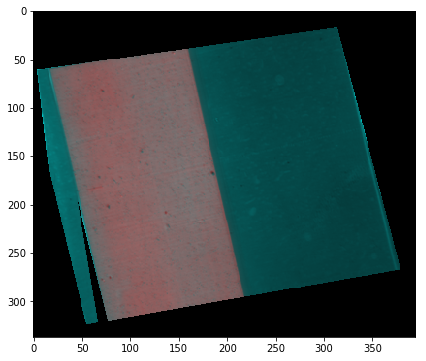

In [382]:
plt.figure(figsize=(8, 6))

plt.imshow(sub)

### Load Segmentation Boxes 

To create artificial image we will load section with the associated segmentation boxes coordinates. 
In this example we're working only with the dataset1. Hence we load the seg. boxes for the dataset1.

In [383]:
index = pd.MultiIndex.from_tuples([('point_1', 'x'), ('point_1', 'y'), ('point_2', 'x'), ('point_2', 'y'),
                                   ('point_3', 'x'), ('point_3', 'y'), ('point_4', 'x'), ('point_4', 'y')])

In [384]:
boxes_tissues_dataset1 = pd.read_csv(f"{WAFER_CROPPED_PATH}/boxes_tissues.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_tissues_dataset1.head()

point_1      point_2      point_3      point_4     
        x    y       x    y       x    y       x    y
0     166   35     314   16     379  265     230  294
1     166   25     312   16     358  271     210  288
2     297  168     312  313      59  371      35  217
3     220  296      72  310      16   56     169   34
4     234  304      91  328      16   79     164   47

In [385]:
boxes_mag_dataset1 = pd.read_csv(f"{WAFER_CROPPED_PATH}/boxes_mag.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
boxes_mag_dataset1.head()

point_1      point_2      point_3      point_4     
        x    y       x    y       x    y       x    y
0      16   59     155   38     216  297      74  321
1      16   38     155   26     196  290      56  303
2     276   16     295  157      33  208      16   68
3     374  277     231  294     182   32     325   16
4     384  277     245  302     178   43     315   16

### Collision Detection

Method able to check only the interesting part of a section (not the background) and output the 'collision boxes' for this section.
We'll then be able to compare these collision boxes to check whether the section will collide with other sections in the full image

In [386]:
def get_collision_boxes(orig_section,nb_boxes = 4, rgb=False, draw = False):
    #Divide the section into 5 block 
    if(rgb == True):
        section = np.mean(orig_section,axis=2)
    else:
        section = orig_section
    
    height_section = section.shape[0]
    width_section = section.shape[1]
    

    limit_boxes = np.zeros([nb_boxes,4],dtype=np.uint16)
    
    cut_height = (height_section//nb_boxes)+1
    for cuts in range(nb_boxes):
        i=0

        if((cuts)*cut_height + 4 >= height_section):
            limit_boxes[cuts] = limit_boxes[cuts-1]
        
        else:
            ymax_box = (cuts+1)*cut_height
            if(ymax_box >= height_section):
                ymax_box = height_section-1
                temp_cut_height = height_section - cut_height*(cuts)
            else:
                temp_cut_height = cut_height
            
            
            # y Min
            for i in range(temp_cut_height):
                if( (np.mean( section[i + cuts*cut_height] ) != 0)):
                    limit_boxes[cuts,0] = i+cuts*cut_height
                    break
            # y Max

            for i in range(cut_height):
                if(np.mean(section[ymax_box-i-1]) != 0):
                    limit_boxes[cuts,1] = ymax_box-i
                    break
            # x Min
            for i in range(width_section):
                if( np.mean( section[ cuts*cut_height+1 : ymax_box , i] ) != 0):
                    limit_boxes[cuts,2] = i
                    break
            # x Max
            for i in range(width_section-1,0,-1):
                if(np.mean(section[cuts*cut_height+1:ymax_box,i]) != 0):
                    limit_boxes[cuts,3] = i
                    break

            # Prevent empty slices
            if(np.mean(limit_boxes[cuts]) == 0 ):
                limit_boxes[cuts] = limit_boxes[cuts - 1]
            if(limit_boxes[cuts,2] == limit_boxes[cuts,3] ):
                limit_boxes[cuts,3] = limit_boxes[cuts,3]+1
            
            for i in range(min(cuts,5)):
                if(np.mean(limit_boxes[cuts-(i+1)]) <= 1 ):
                    limit_boxes[cuts-(i+1)] = limit_boxes[cuts]
            

            
            if((limit_boxes[cuts,2] <= 1) and  (limit_boxes[cuts,3] <= 1)):
                limit_boxes[cuts] = limit_boxes[cuts - 1]
            

        
          
        if(draw):
            pts = np.array([limit_boxes[cuts,2],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,0], limit_boxes[cuts,3],limit_boxes[cuts,1], limit_boxes[cuts,2],limit_boxes[cuts,1] ] )
            pts = pts.reshape((-1,1,2))
            section = cv.polylines(section, np.int32([pts]), True, color=compute_rgb(tissue_color), thickness=1)
            plt.imshow(section)
    return limit_boxes
        

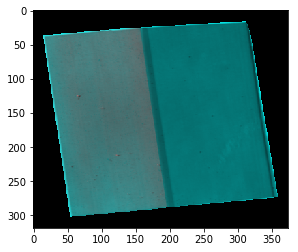

In [387]:
path_img= f"{WAFER_CROPPED_PATH}/extract/1.tif"
if(rgb==True):
    section = cv.imread(path_img)
else:
    section = cv.imread(path_img,0)
plt.imshow(section)

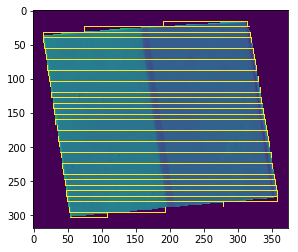

In [388]:
t = get_collision_boxes(section,40,rgb,True)

### Create Artificial Image

Extract randomly section and place it randomly in the image. For each section, compute and store the segmentation boxes coordinates of the section (brain + mag)

In [389]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_{path_rgb}_wafer{str(DATASET_NUMBER)}.tif"
if(rgb==True):
    backgnd = cv.imread(path_img)
else:
    backgnd = cv.imread(path_img,0)

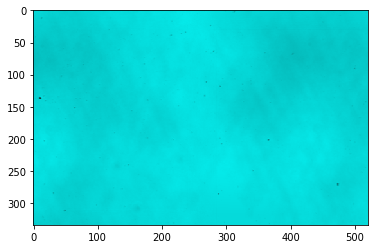

In [390]:
plt.imshow(backgnd)

In [391]:
# Size of the image
print(backgnd.shape)
grid_background = 4
height, width = backgnd.shape[0]*grid_background, backgnd.shape[1]*grid_background  # means 10x10 background images
print(height, width)

if(rgb==True):
    full_image = np.zeros([height, width,3],dtype=np.uint8)
else:
    full_image = np.zeros([height, width],dtype=np.uint8)
full_image.fill(0)

(334, 521, 3)
1336 2084


In [392]:
# NB of artificial images to create
nb_artificial_images = 1
random.seed(22)

if(DATASET_NUMBER == 1):
    max_num_section = 100
elif(DATASET_NUMBER == 2):
    max_num_section = 35
else:
    max_num_section = 70

In [393]:
for iter_img in range(nb_artificial_images): 
    height, width = backgnd.shape[0]*grid_background, backgnd.shape[1]*grid_background 
    if(rgb==True):
        full_image = np.zeros([height, width,3],dtype=np.uint8)
    else:
        full_image = np.zeros([height, width],dtype=np.uint8)
    full_image.fill(0)  
    nb_sections = random.randint(90, 120)
    
    f_seg_tissues_artif = open(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif{str(DATASET_NUMBER)}_{iter_img}.txt","w+")
    f_seg_mag_artif= open(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif{str(DATASET_NUMBER)}_{iter_img}.txt","w+")

    for index_section in range(nb_sections):

        # Section selection
        # section_num will be use to load the data image, and to load the corrects segmentation boxes
        
        section_num = random.randint(0, max_num_section)
        

        path_img= f"{WAFER_CROPPED_PATH}/extract/{str(section_num)}.tif"
        if(rgb==True):
            section = cv.imread(path_img)
        else:
            section = cv.imread(path_img,0)
        height_section = section.shape[0]
        width_section = section.shape[1]

        xpos_section = random.randint(0, width - width_section- 1)
        ypos_section = random.randint(0, height - height_section - 1)
        
        # Collision boxes to not interfere with other sections
        nb_collision_boxes = 20
        collision_boxes_section = get_collision_boxes(section, nb_collision_boxes, rgb, False)

        free_place = True
        for i in range(nb_collision_boxes):
            
            ymin = ypos_section+collision_boxes_section[i][0]
            ymax = ypos_section+collision_boxes_section[i][1]
            xmin = xpos_section+collision_boxes_section[i][2]
            xmax = xpos_section+collision_boxes_section[i][3]

            # check collision box 
            if(rgb==True):
                if(np.mean(np.mean(full_image[ymin:ymax, xmin:xmax],axis=2)) != 0):
                    free_place = False
            else:
                if(np.mean(full_image[ymin:ymax, xmin:xmax]) != 0):
                    free_place = False



        # Find an area in the image free (all pixels = 255)
        timeout = 0

        while(free_place == False):
            xpos_section = random.randint(0, width - width_section- 1)
            ypos_section = random.randint(0, height - height_section - 1)

            free_place = True
            for i in range(nb_collision_boxes):
                #print(i)
                ymin = ypos_section+collision_boxes_section[i][0]
                ymax = ypos_section+collision_boxes_section[i][1]
                xmin = xpos_section+collision_boxes_section[i][2]
                xmax = xpos_section+collision_boxes_section[i][3]


                # check collision box 
                if(rgb==True):
                    if(np.mean(np.mean(full_image[ymin:ymax, xmin:xmax],axis=2)) != 0):
                        free_place = False
                else:
                    if(np.mean(full_image[ymin:ymax, xmin:xmax]) != 0):
                        free_place = False

            if(timeout>10000):
                # end loop no more space
                index_section = nb_sections+1 
                print("No more space")
                break
            else:
                timeout= timeout+1

        if(timeout > 10000):
            break


        # Integrate the section into the full image
        for i in range(height_section):
            for j in range(width_section):
                if(rgb==True):
                    if(np.mean(section[i,j]) != 0):
                        full_image[ypos_section+i,xpos_section+j] = section[i,j]
                else:
                    if(section[i,j] != 0):
                        full_image[ypos_section+i,xpos_section+j] = section[i,j]



        #Store the new segmentation position Brain tissues in txt file
        temp_tissue = boxes_tissues_dataset1.iloc[section_num]

        seg_tissues_p1_x = temp_tissue['point_1']['x'] + xpos_section  
        seg_tissues_p1_y = temp_tissue['point_1']['y'] + ypos_section  

        seg_tissues_p2_x = temp_tissue['point_2']['x'] + xpos_section  
        seg_tissues_p2_y = temp_tissue['point_2']['y'] + ypos_section  

        seg_tissues_p3_x = temp_tissue['point_3']['x'] + xpos_section  
        seg_tissues_p3_y = temp_tissue['point_3']['y'] + ypos_section 

        seg_tissues_p4_x = temp_tissue['point_4']['x'] + xpos_section 
        seg_tissues_p4_y = temp_tissue['point_4']['y'] + ypos_section 

        f_seg_tissues_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_tissues_p1_x,seg_tissues_p1_y,  seg_tissues_p2_x,seg_tissues_p2_y,  seg_tissues_p3_x,seg_tissues_p3_y,  seg_tissues_p4_x,seg_tissues_p4_y))

        #Store the new segmentation position Mag in txt file
        temp_mag = boxes_mag_dataset1.iloc[section_num]

        seg_mag_p1_x = temp_mag['point_1']['x'] + xpos_section  
        seg_mag_p1_y = temp_mag['point_1']['y'] + ypos_section  

        seg_mag_p2_x = temp_mag['point_2']['x'] + xpos_section  
        seg_mag_p2_y = temp_mag['point_2']['y'] + ypos_section  

        seg_mag_p3_x = temp_mag['point_3']['x'] + xpos_section  
        seg_mag_p3_y = temp_mag['point_3']['y'] + ypos_section 

        seg_mag_p4_x = temp_mag['point_4']['x'] + xpos_section 
        seg_mag_p4_y = temp_mag['point_4']['y'] + ypos_section 

        f_seg_mag_artif.write("%d,%d\t%d,%d\t%d,%d\t%d,%d\r\n" % (seg_mag_p1_x,seg_mag_p1_y,  seg_mag_p2_x,seg_mag_p2_y,  seg_mag_p3_x,seg_mag_p3_y,  seg_mag_p4_x,seg_mag_p4_y))


    f_seg_tissues_artif.close()
    f_seg_mag_artif.close()
    
    
    # Add background
    width_subbckgnd = backgnd.shape[1]
    height_subbckgnd = backgnd.shape[0]

    for ind_y in range(grid_background):
        for ind_x in range(grid_background):

            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(np.mean(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j]) == 0):
                        full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
                            
    
    path_artificial_img = f"{AUGMENTED_DATASET_PATH}/artificial_images/artificial_image{str(DATASET_NUMBER)}_{iter_img}.tif"
    cv.imwrite(path_artificial_img, full_image)
    

No more space


In [ ]:
plt.figure(figsize=(15, 7))

plt.imshow(full_image)

In [ ]:
cv.imwrite(f"{TEST_IMAGES_PATH}/test_artificial_images.tiff", full_image)

In [ ]:
# remove it since we don't need it in file system
if os.path.exists(f"{TEST_IMAGES_PATH}/test_artificial_images.tiff"):
    os.remove(f"{TEST_IMAGES_PATH}/test_artificial_images.tiff")

### Add Background (already done in previous part)

In [ ]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_1.tif"
if os.path.isfile(path_img):
    backgnd = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
path_img= f"{AUGMENTED_DATASET_PATH}/background_2.tif"
if os.path.isfile(path_img):
    backgnd_2 = cv.imread(path_img, 0)
else:
    print ("The file " + path_img + " does not exist.")

In [ ]:
plt.imshow(backgnd, cmap='gray')

In [ ]:
plt.imshow(backgnd_2, cmap='gray')

In [ ]:
width_subbckgnd = backgnd.shape[1]
height_subbckgnd = backgnd.shape[0]

for ind_y in range(10):
    for ind_x in range(10):
        # Choice between 2 background
        choice_bckgnd = random.randint(1,2)
        
        #No objects on the complete background gridcell
        if(np.mean(full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)]) == 0):
            if(choice_bckgnd== 1):
                full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd
            else:
                full_image[backgnd.shape[0]*ind_y:backgnd.shape[0]*(ind_y+1),backgnd.shape[1]*ind_x:backgnd.shape[1]*(ind_x+1)] =   backgnd_2
        
        else:
            for i in range(backgnd.shape[0]):
                for j in range(backgnd.shape[1]):
                    if(full_image[height_subbckgnd*ind_y + i , width_subbckgnd*ind_x + j] == 0):
                        if(choice_bckgnd == 1):
                            full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd[i,j]
                        else:
                            full_image[height_subbckgnd*ind_y + i, width_subbckgnd*ind_x + j] = backgnd_2[i,j]
        

In [ ]:
plt.figure(figsize=(40, 30))
plt.imshow(full_image)

In [ ]:
cv.imwrite(f"{TEST_IMAGES_PATH}/test_artificial_images_bckgn.tiff", full_image)

### Segmentation 

Load segmentation boxes recently created for artificial image (brain + mag)

In [263]:
seg_tissues_artif = pd.read_csv(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_tissues_artif{str(DATASET_NUMBER)}_{iter_img}.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_tissues_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1535   785    1530   730    1662   723    1653   773
1     593   319     641   350     558   456     525   417
2     787  1059     813  1107     691  1161     681  1110
3    1286   983    1266  1033    1146   977    1178   935
4     176   663     202   711      80   765      70   714

In [264]:
seg_mag_artif = pd.read_csv(f"{AUGMENTED_DATASET_PATH}/artificial_images/seg_mag_artif{str(DATASET_NUMBER)}_{iter_img}.txt", sep="\t|,", header=None, names=index, engine='python')
#Without scale
seg_mag_artif.head()

point_1       point_2       point_3       point_4      
        x     y       x     y       x     y       x     y
0    1541   834    1536   787    1654   775    1648   823
1     551   291     592   318     526   417     490   379
2     761  1015     786  1058     681  1110     670  1062
3    1306   936    1288   982    1179   937    1207   896
4     150   619     175   662      70   714      59   666

In [270]:
# Load recently created artificial images
path_img= f"{AUGMENTED_DATASET_PATH}/artificial_images/artificial_image{str(DATASET_NUMBER)}_{iter_img}.tif"
if os.path.isfile(path_img):
    extrct_img = cv.imread(path_img)
else:
    print ("The file " + path_img + " does not exist.")

In [271]:
extrct_img = draw_labels(extrct_img, seg_mag_artif, thickness, magnet_color, fill_poly)

In [272]:
extrct_img = draw_labels(extrct_img, seg_tissues_artif, thickness, tissue_color, fill_poly)

In [273]:
legend_elements = [Line2D([0], [0], color=magnet_color, lw=thickness, label='Magnet Part'),
                   Line2D([0], [0], color=tissue_color, lw=thickness, label='Brain Part')]

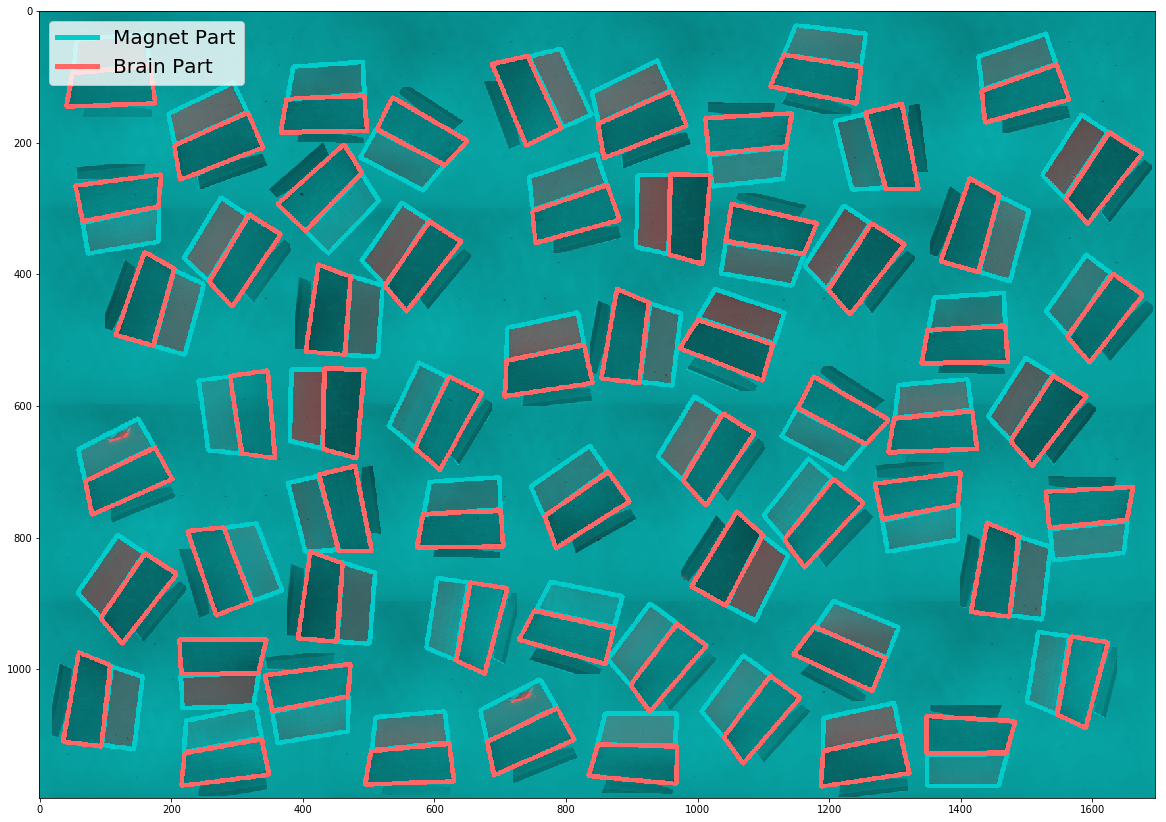

In [274]:
plt.figure(figsize=(20, 15))
plt.imshow(extrct_img)

plt.legend(handles=legend_elements, loc='upper left', fontsize=20)